In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage import binary_closing, binary_dilation, binary_erosion, binary_opening
from numpy.fft import fft2, fftshift, ifft2, ifftshift, rfft2, irfft2
import matplotlib.patches as patches
import skimage.restoration as restore
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import cv2 
from scipy.ndimage import map_coordinates
from IPython import display
import time
import os
import tifffile as tiff

In [2]:
def drawnow(fig):
    display.display(fig)
    display.clear_output(wait=True)
    time.sleep(.01)

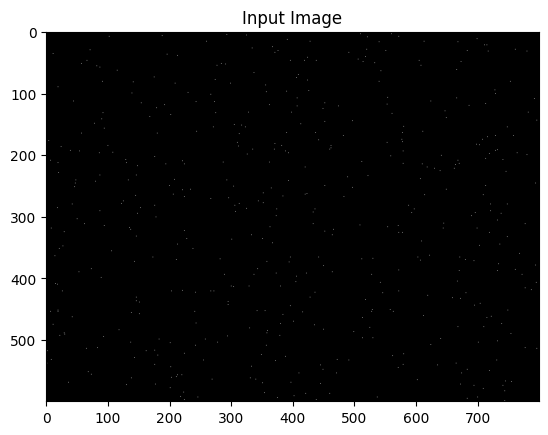

In [3]:
img = plt.imread("synthetic/random_1px.png")

if len(img.shape) > 2:
    print("Converting image to grayscale")
    img = img.mean(axis=2)

plt.imshow(img, cmap="gray")
plt.title("Input Image")
plt.show()

# Polar Transforms

In [4]:
def polar_transform(img, center, output=None):
    r = (np.array(img.shape[:2])**2).sum()**0.5/2

    if output is None:
        shp = int(round(r)), int(round(r*2*np.pi))
        output = np.zeros(shp, dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    
    out_h, out_w = output.shape
    r_samples = np.linspace(0, r, out_h)
    theta_samples = np.linspace(0, np.pi*2, out_w)
    
    xs = r_samples[:,None] * np.cos(theta_samples) + center[1]
    ys = r_samples[:,None] * np.sin(theta_samples) + center[0]
    
    map_coordinates(img, (ys, xs), order=1, output=output)
    return output

In [5]:
def inverse_polar_transform(img, center, output=None):
    r = img.shape[0]
    
    if output is None:
        output = np.zeros((r*2, r*2), dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    
    out_h, out_w = output.shape
    
    y_samples, x_samples = np.mgrid[:out_h, :out_w]
    y_samples -= center[0]
    x_samples -= center[1]
    
    rs = (y_samples * y_samples + x_samples * x_samples) **0.5
    ts = np.arccos(x_samples / (rs + 1e-8))
    ts[y_samples<0] = np.pi * 2 - ts[y_samples<0]
    ts *= (img.shape[1]-1) / (np.pi * 2)
    
    map_coordinates(img, (rs, ts), order=1, output=output)
    return output

# Utils

In [6]:
def generate_star_trails(img, kernel):
    return convolve2d(img, kernel, mode='same')

In [7]:
def contrast_stetch(img):
    max = img.max()
    min = img.min()
    return (img - min) / (max - min)

In [8]:
def plot_polar_img(img, mode=0, title=''):
    if mode == 0:
        plt.imshow(img, cmap='gray', aspect='auto')
    else:
        plt.imshow(img, aspect='auto')

    plt.title(title)

In [9]:
def save_images(recon_images: dict, path: str):
    if not os.path.exists(path):
        os.makedirs(path)

    for key, val in recon_images.items():
        val = val.astype(np.float32)
        tiff.imsave(os.path.join(path, key) + '.tif', val)

In [38]:
def compute_stats(true_img: np.ndarray, recon_images: dict, path: str):
    file = open(os.path.join(path, "stats.txt"), 'w')
    file.write("Method\tPSNR\tSIMM\n")

    true_img = true_img.astype(np.float32)

    for key, val in recon_images.items():
        val = val.astype(np.float32)
        psnr = peak_signal_noise_ratio(true_img, val)
        simm = structural_similarity(true_img, val, win_size=11, data_range=1.0)
        file.write(f"{key}\t{psnr:.05}\t{simm:.05}\n")
        
    file.close()

# Center 

In [11]:
def find_center(img, threshold, ax=None):

    # Binarize Image
    img = contrast_stetch(img)
    bin_img = (img > threshold).astype('int')

    H, W = img.shape[:2]
    factor = 1
    if (H > 1000 or W > 1000):
        factor = max(H, W) // 1000

    # Dilating and subsampling
    bin_img = binary_dilation(bin_img, np.ones((factor, factor)))
    bin_img = bin_img[::factor, ::factor].astype(np.uint8) * 255
    
    # To remove noise
    blur = cv2.GaussianBlur(bin_img, ksize=(31, 31), sigmaX=1)

    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, 1, minDist=200, param1=50, param2=30, minRadius=10, maxRadius=0)
    circles = np.around(circles).reshape((-1, 3))
    
    # Create a figure. Equal aspect so circles look circular
    if ax is None:
        fig, ax = plt.subplots(1)
        
    ax.set_aspect('equal')

    # Show the image
    ax.imshow(img, cmap="gray")

    for circ in circles[:1]:
        ax.add_patch(patches.Circle(circ[:2] * factor, circ[2], edgecolor='r', linewidth=1, fill=False))
        ax.add_patch(patches.Rectangle(circ[:2] * factor, 20*factor, 20*factor))

    ax.set_title("Hough Transform")
    # # Show the image
    # # plt.show()
    
    circ = circles[0]
    circ[1::-1] = circ[:2]
    print("Predicted Center: ", circ[:2] * factor)
    return circ[:2] * factor
    
    

# Deconv

In [12]:
def estimate_deblurring_kernel(img, time):
    '''
    time: (in minutes) the duration of exposure
    '''
    H, W = img.shape[:2]
    r = (np.array(img.shape[:2])**2).sum()**0.5/2
    total_theta = int(round(2 * np.pi * r))
    estimated_theta = total_theta * (time / (24 * 60))
    estimated_theta = np.around(estimated_theta).astype('int')

    estimated_kernel = np.zeros((1, estimated_theta)) # Is it correct though?
    estimated_kernel[0, :estimated_theta] = 1 / estimated_theta

    return estimated_kernel

## Wiener Decovolution

In [13]:
def wiener_deconvolution(image, psf, nsr=0.01):
    """
    image (np.array) : MxN
    psf (np.array)  : MxN 
    nsr (noise to signal ratio - 1/SNR from above derivation) : float
    """
    # YOUR CODE HERE
    deblurred_image = np.zeros_like(image)
    Y = fftshift(fft2(image))
    H = fftshift(fft2(psf))
    X = Y * np.conj(H) / (nsr + np.conj(H) * H)
    deblurred_image = ifftshift(ifft2(X))
    deblurred_image = np.abs(deblurred_image)
    return deblurred_image

## Vanilla GD

In [14]:
def F(x):
    return rfft2(x,axes=(0,1))

def Fh(x):
    return irfft2(x,axes=(0,1))

In [32]:
def crop(x):
    M,N = x.shape
    rl = M//4
    ru = 3*np.ceil(M/4)
    cl = N//4
    cu = 4*np.ceil(N/4)
    return x[M//4:3*M//4, N//4:3*N//4]

def pad(psf, x):
    M, N = x.shape   
    H, W = psf.shape
    pad_psf = np.zeros((2*H, 2*W))
    pad_psf[M//2:M//2+psf.shape[0], N//2:N//2+psf.shape[1]] = psf
    return pad_psf

In [16]:
def A(x, pad_psf):
    H_bar = F(ifftshift(pad_psf))
    H = np.real(Fh(H_bar * F(x)))
    return crop(H)   

def Ah(y, pad_psf):
    H = F(ifftshift(pad_psf))
    H_star = np.conj(H)
    return np.real(Fh(H_star*F(pad(y, y))))

In [17]:
# Testing the implemented functions.
img = np.random.randn(300, 400)
print(img.shape)
kernel = np.ones((1, 100)) / 100

psf = np.zeros_like(img)
kh, kw = kernel.shape
H, W = psf.shape
psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

[M,N] = img.shape
x = np.random.rand(2*M, 2*N)
y = np.random.rand(M,N)
pad_psf = pad(psf, x)

Ax_y = np.sum(A(x, pad_psf)*y)
x_Ahy = np.sum(x*Ah(y, pad_psf))

## They should have the same value.
print('<A(x),y> =',Ax_y)
print('<x,Ah(y)>=',x_Ahy)


(300, 400)
<A(x),y> = 29931.430174590867
<x,Ah(y)>= 29931.430174590863


In [18]:
def vanilla_gd(meas, pad_psf, n_iters=500):
    M, N = meas.shape
    x_k = np.zeros((2*M, 2*N))   #Initialize with zeros
    mu = 1    #Step size

    fig = plt.figure()   #Initialize figure
    im_obj = plt.imshow(x_k, cmap='gray', aspect='auto')  
    title_obj = plt.title('Gradient Descent, Iteration {}'.format(0))

    for k in range(n_iters):
        x_k = x_k - mu * Ah(A(x_k, pad_psf) - meas, pad_psf)
        
        ## Display progress
        if k%10 == 0:
            im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
            plt.title('Gradient Descent, Iteration {}'.format(k))
            drawnow(fig)

    x_gd = x_k

    im_obj.set_data(np.maximum(crop(x_k)/np.max(x_k),0))
    plt.title('Gradient Descent, Iteration {}'.format(k))
    plt.show()

    return x_gd

## FISTA

In [19]:
def gd_fista(meas, pad_psf, n_iters=500, mu=1):
    M, N = meas.shape

    # Initialize variables
    t_k = 1    #Momentum parameter
    x_k = np.zeros((2*M, 2*N))   # Image
    y_k = np.zeros((2*M, 2*N))
    z_k = np.zeros((2*M, 2*N))

    # Initialize plotting
    fig = plt.figure()
    im_obj = plt.imshow(x_k, cmap='gray', aspect='auto')    
    title_obj = plt.title('FISTA, Iteration {}'.format(0))

    for k in range(n_iters):
        # Update momentum parameters
        t_k1 = (1 + np.sqrt(1+4*t_k*t_k)) / 2
        beta = (t_k - 1) / t_k1
        y_k1 = x_k - mu * Ah(A(x_k, pad_psf) - meas, pad_psf)
        z_k1 = np.maximum(0, y_k1)
        x_k = z_k1 + beta * (z_k1 - z_k)
        t_k = t_k1
        z_k = z_k1
        #print("Beta:", beta, " t_k: ", t_k)
        
        if k%10 == 0:
            im_obj.set_data((np.maximum(crop(z_k)/np.max(z_k),0)))
            plt.title('FISTA, Iteration {}'.format(k))
            drawnow(fig)

    x_fista = z_k 

    im_obj.set_data(np.maximum(crop(z_k)/np.max(z_k),0))
    plt.title('FISTA, Iteration {}'.format(k))
    plt.show()

    return x_fista

## FISTA + Regularization

In [20]:
def gd_fista_tikhonov_reg(meas, pad_psf, n_iters=500, mu=1, lamda=0.00005):
    M, N = meas.shape

    ## Function to compute gradient for the Tikhonov Regulariation Term.
    kernel_tv = np.asarray([[0, -1, 0], [-1, 4, -1], [0, -1 , 0]])
    
    # raise NotImplementedError()

    # Initialize variables
    t_k = 1    #Momentum parameter
    x_k = np.zeros((2*M, 2*N))   # Image
    y_k = np.zeros((2*M, 2*N))
    z_k = np.zeros((2*M, 2*N))
    mu = 1   #Step size
    # lamda = 0.00005 # Step Size for regularizer

    delta_x = np.zeros_like(x_k)
    # Initialize plotting
    fig = plt.figure()
    im_obj = plt.imshow(x_k, cmap='gray', aspect='auto')    
    title_obj = plt.title('Fista + Tikhonov Regulariation, Iteration {}'.format(0))


    for k in range(n_iters):
        # Update momentum parameters
        t_k1 = (1 + np.sqrt(1+4*t_k*t_k)) / 2
        beta = (t_k - 1) / t_k1
        # for i in range(3):
        #     delta_x[:,:,i] = convolve2d(x_k[:,:,i], kernel, mode='same')
        
        delta_x = convolve2d(x_k, kernel_tv, mode='same')
        y_k1 = x_k - mu * (Ah(A(x_k, pad_psf) - meas, pad_psf) + 2 * lamda * delta_x)
        z_k1 = np.maximum(0, y_k1)
        x_k = z_k1 + beta * (z_k1 - z_k)
        t_k = t_k1
        z_k = z_k1
        if k%10 == 0:
            im_obj.set_data((np.maximum(crop(z_k)/np.max(z_k),0)))
            plt.title('Fista + Tikhonov Regulariation, Iteration {}'.format(k))
            drawnow(fig)


    x_fista_reg = z_k 
    im_obj.set_data(np.maximum(crop(z_k)/np.max(z_k),0))
    plt.title('Fista + Tikhonov Regulariation, Iteration {}'.format(k))
    plt.show()

    return x_fista_reg

In [39]:
def gd_fista_total_variation_reg(meas, pad_psf, n_iters=500, mu=1, lamda=0.00005):

    def gradient_tv(x):
        grad = np.zeros_like(x)
        grad[:, :-1] += x[:, :-1] - x[:, 1:]
        grad[:, 1:] += x[:, 1:] - x[:, :-1]
        grad[:-1, :] += x[:-1, :] - x[1:, :]
        grad[1:, :] += x[1:, :] - x[:-1, :]
        return grad

    M, N = meas.shape

    # Initialize variables
    t_k = 1    #Momentum parameter
    x_k = np.zeros((2*M, 2*N))   # Image
    y_k = np.zeros((2*M, 2*N))
    z_k = np.zeros((2*M, 2*N))
    mu = 1   #Step size
    # lamda = 0.00005 # Step Size for regularizer

    delta_x = np.zeros_like(x_k)
    # Initialize plotting
    fig = plt.figure()
    im_obj = plt.imshow(x_k, cmap='gray', aspect='auto')    
    title_obj = plt.title('Fista + TV Regulariation, Iteration {}'.format(0))


    for k in range(n_iters):
        # Update momentum parameters
        t_k1 = (1 + np.sqrt(1+4*t_k*t_k)) / 2
        beta = (t_k - 1) / t_k1
        # for i in range(3):
        #     delta_x[:,:,i] = convolve2d(x_k[:,:,i], kernel, mode='same')
        
        delta_x = gradient_tv(x_k)
        y_k1 = x_k - mu * (Ah(A(x_k, pad_psf) - meas, pad_psf) + 2 * lamda * delta_x)
        z_k1 = np.maximum(0, y_k1)
        x_k = z_k1 + beta * (z_k1 - z_k)
        t_k = t_k1
        z_k = z_k1
        if k%10 == 0:
            im_obj.set_data((np.maximum(crop(z_k)/np.max(z_k),0)))
            plt.title('Fista + TV Regulariation, Iteration {}'.format(k))
            drawnow(fig)


    x_fista_tv_reg = z_k 
    im_obj.set_data(np.maximum(crop(z_k)/np.max(z_k),0))
    plt.title('Fista + TV Regulariation, Iteration {}'.format(k))
    plt.show()

    return x_fista_tv_reg

# Pipelines

## Natural Images

1. Load the image and convert it to grayscale
2. Binarize the image and get the mask image
3. Find center
4. Polar transform the image with the center
5. Estimate Blur kernel
6. Form PSF and Padded PSF
7. Performing Deblurring
8. Display results
9. Compute Stats (TODO)

In [40]:
def preprocessing_natural_image(img_path: str, th: float, time: int, center: tuple = None):
    # 1. Load the image and convert it to grayscale
    img = plt.imread(img_path)

    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if img_path.split('.')[-1] != 'png':
        img = np.asarray(img / 255, dtype=np.float32)

    _ = plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")

    # 2. Binarize the image and get the mask image
    mask = (img > th).astype(np.uint8)

    plt.subplot(2, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Mask")

    masked_img = mask * img

    plt.subplot(2, 3, 3)
    plt.imshow(masked_img, cmap='gray')
    plt.axis('off')
    plt.title("Masked Image")

    # 3. Find center
    ax_center = plt.subplot(2, 3, 4)
    center_calc = find_center(mask, threshold=0, ax=ax_center)
    if center is not None:
        assert len(center) == 2, "Center is not a 2-tuple"
        center_calc = center

    center = center_calc        

    # 4. Polar transform the image with the center

    polar_img = polar_transform(masked_img, center)

    plt.subplot(2, 3, 5)
    plt.axis('off')
    plot_polar_img(polar_img, title="Polar Transform")

    # 5. Estimate Blur kernel
    kernel = estimate_deblurring_kernel(masked_img, time=time)
    print("Kernel Shape: ", kernel.shape, kernel.sum())

    # 6. Form PSF and Padded PSF
    psf = np.zeros_like(polar_img)
    kh, kw = kernel.shape
    H, W = psf.shape
    psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

    pad_psf = np.zeros((2*H, 2*W))
    H, W = pad_psf.shape
    pad_psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

    plt.subplot(2, 3, 6)
    plt.imshow(psf, cmap='gray', aspect='auto')
    plt.axis('off')
    plt.title("PSF")

    _.suptitle(f'Processing for Star Trails - {time} Minutes', fontsize=10)

    plt.show()

    return polar_img, psf, pad_psf, center, img

## Synthetic Pipeline

1. Load the image and convert it to grayscale
2. Decide on center
3. Generate the kernel
4. Polar transform the image
5. Apply the kernel
6. Find center (and see how good the center finidng method is)
7.  Form PSF and Padded PSF
8.  Performing Deblurring
9.  Display results
10. Compute Stats (TODO)

In [41]:
def preprocessing_synthetic_images(img_path: str, th: float, deg: int, center: tuple = None):
     # 1. Load the image and convert it to grayscale, generate masked_img
    img = plt.imread(img_path)

    _ = plt.figure(figsize=(20, 10))

    if len(img.shape) > 2:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if img_path.split('.')[-1] != 'png':
        img = np.asarray(img / 255, dtype=np.float32)

    plt.subplot(2, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Grayscale Image")

    mask = (img > th).astype(np.uint8)

    plt.subplot(2, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title("Mask")

    masked_img = mask * img

    # 2. Decide on center
    # center = (300, 400)

    # 3. Generate the kernel
    r = (np.array(img.shape[:2])**2).sum()**0.5/2
    total_theta = int(round(r*2*np.pi))

    degrees = deg
    kernel_length = int(round((degrees * total_theta) / 360))

    kernel = np.ones((1, kernel_length)) / kernel_length
    print("Kernel Length: ", kernel_length, kernel.sum())

    # 4. Polar transform the image
    polar_img = polar_transform(masked_img, center)
    plt.subplot(2, 3, 3)
    plt.axis('off')
    plot_polar_img(polar_img, title="Polar Image")

    # 5. Apply the kernel
    blur_polar_img = generate_star_trails(polar_img, kernel)
    plt.subplot(2, 3, 4)
    plt.axis('off')
    plot_polar_img(blur_polar_img, title="Blur Polar Image")

    # 6. Find Center
    ax_center = plt.subplot(2, 3, 5)
    inv_polar_img = inverse_polar_transform(blur_polar_img, center, output=img.shape)
    calc_center = find_center(inv_polar_img, threshold=0, ax=ax_center)

    print("True Center: ", center)

    # 6. Form PSF and Padded PSF
    psf = np.zeros_like(polar_img)
    kh, kw = kernel.shape
    H, W = psf.shape
    psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

    pad_psf = np.zeros((2*H, 2*W))
    H, W = pad_psf.shape
    pad_psf[H//2-kh//2:H//2-kh//2+kh, W//2-kw//2:W//2-kw//2+kw] = kernel

    plt.subplot(2, 3, 6)
    plt.axis('off')
    plt.imshow(pad_psf, cmap='gray', aspect='auto')
    plt.title('PSF')

    _.suptitle(f'Processing for Synthetic Trails - {deg} Degrees', fontsize=30)

    plt.show()
    
    return blur_polar_img, psf, pad_psf, center, img

## Deconvoltion Manager

In [45]:
def perform_deconvolution(polar_img: np.ndarray, psf:np.ndarray, pad_psf: np.ndarray, center: tuple, img: np.ndarray, iterations: int = 500, nsr: float = 1e-3):
    wiener_out = wiener_deconvolution(polar_img, psf, nsr=nsr)
    gd_out = vanilla_gd(polar_img, pad_psf, n_iters=iterations)
    fista_out = gd_fista(polar_img, pad_psf, n_iters=iterations)
    gd_fista_tikhonov_out = gd_fista_tikhonov_reg(polar_img, pad_psf, n_iters=iterations)
    gd_fista_tv = gd_fista_total_variation_reg(polar_img, pad_psf, n_iters=iterations, lamda=0.05)
    polar_img += polar_img.max() * 1e-5
    rl_out = restore.richardson_lucy(polar_img, kernel, num_iter=iterations)

    # 8. Display results
    f = plt.figure(figsize=(15, 15))
    plt.subplot(3, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title("Original Image")

    plt.subplot(3, 3, 2)
    wiener_out1 = contrast_stetch(wiener_out)
    wiener_recon = inverse_polar_transform(wiener_out1, center=center, output=img.shape)
    plt.title("Wiener Deconvolution")
    plt.axis('off')
    plt.imshow(wiener_recon, cmap='gray')

    plt.subplot(3, 3, 3)
    rl_out1 = contrast_stetch(rl_out)
    rl_recon = inverse_polar_transform(rl_out1, center=center, output=img.shape)
    plt.title("Richardson Lucy Deconvolution")
    plt.axis('off')
    plt.imshow(rl_recon, cmap='gray')

    plt.subplot(3, 3, 4)
    gd_out1 = contrast_stetch(crop(gd_out))
    gd_recon = inverse_polar_transform(gd_out1, center=center, output=img.shape)
    plt.title("GD Deconvolution")
    plt.axis('off')
    plt.imshow(gd_recon, cmap='gray')

    plt.subplot(3, 3, 5)
    fista_out1 = contrast_stetch(crop(fista_out))
    fista_recon = inverse_polar_transform(fista_out1, center=center, output=img.shape)
    plt.title("FISTA Deconvolution")
    plt.axis('off')
    plt.imshow(fista_recon, cmap='gray')

    plt.subplot(3, 3, 6)
    gd_fista_tikhonov_out1 = contrast_stetch(crop(gd_fista_tikhonov_out))
    gd_fista_tikhonov_recon = inverse_polar_transform(gd_fista_tikhonov_out1, center=center, output=img.shape)
    plt.title("FISTA+Reg  Deconvolution")
    plt.axis('off')
    plt.imshow(gd_fista_tikhonov_recon, cmap='gray')

    plt.subplot(3, 3, 7)
    gd_fista_tv1 = contrast_stetch(crop(gd_fista_tv))
    gd_fista_tv_recon = inverse_polar_transform(gd_fista_tv1, center=center, output=img.shape)
    plt.title("FISTA+TV  Deconvolution")
    plt.axis('off')
    plt.imshow(gd_fista_tv_recon, cmap='gray')

    f.suptitle(f'Deconvolution Results', fontsize=10)

    plt.show()

    # Save them too
    recon_images = {}
    recon_images['wiener_recon'] = wiener_recon
    recon_images['rl_recon'] = rl_recon
    recon_images['gd_recon'] = gd_recon
    recon_images['fista_recon'] = fista_recon
    recon_images['gd_fista_tikhonov_recon'] = gd_fista_tikhonov_recon
    recon_images['gd_fista_tv_recon'] = gd_fista_tv_recon

    return recon_images

# Tests

## Synthetic

Kernel Length:  45 1.0000000000000002
Predicted Center:  [420. 312.]
True Center:  (400, 320)


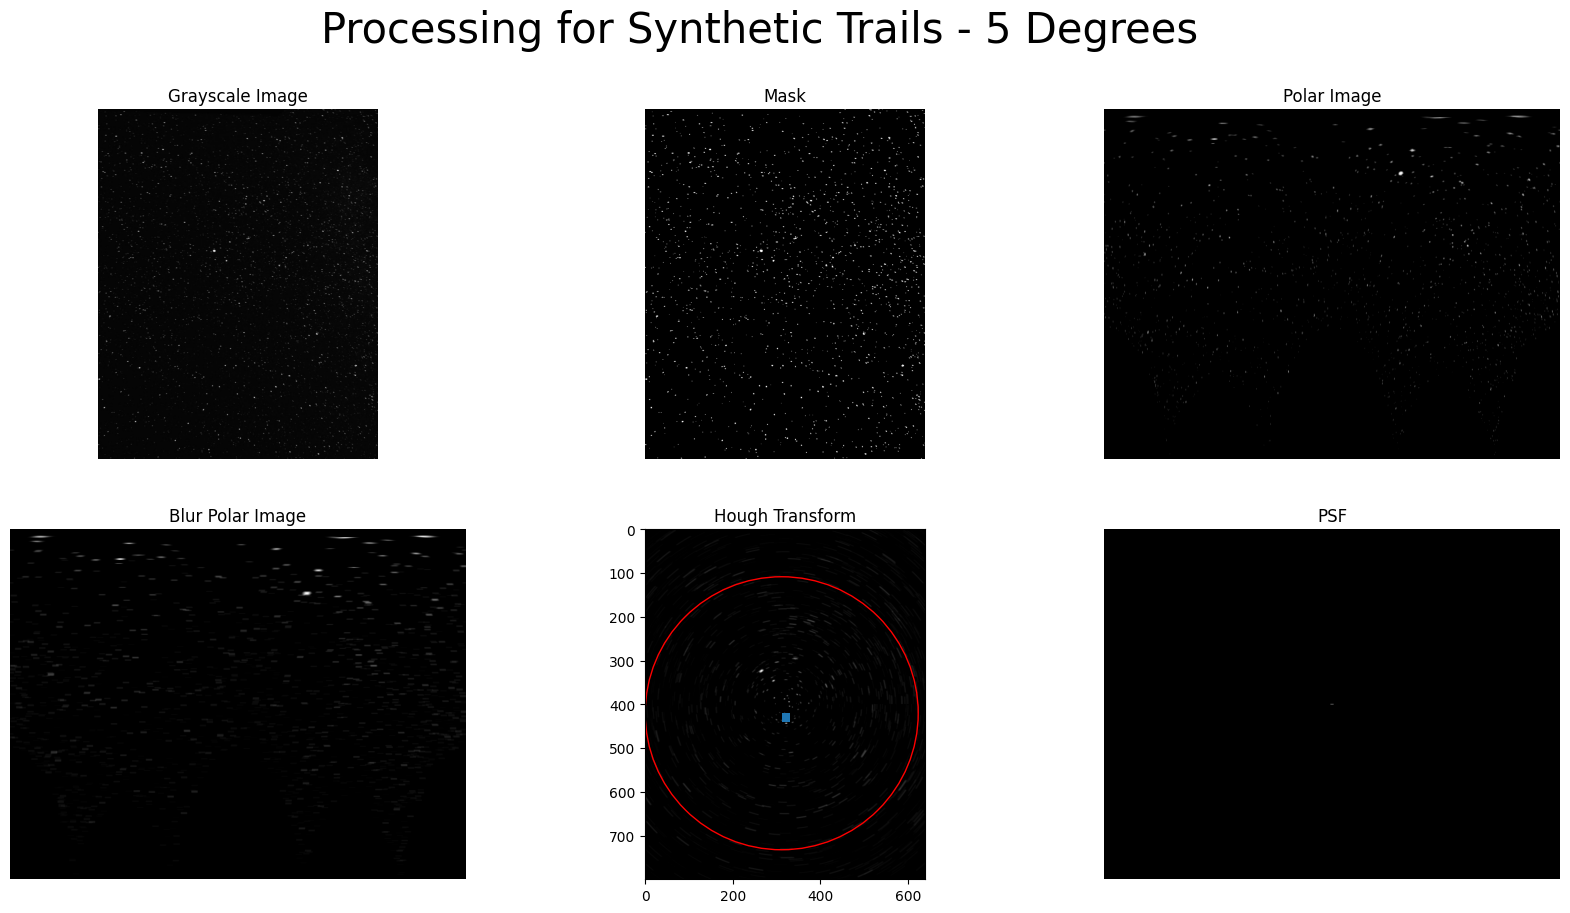

In [46]:
res_path = "results/synth_05deg/"
polar_img, psf, pad_psf, center, img = preprocessing_synthetic_images("real/stars3.jpg", th=0.2, deg=5, center=(400, 320))

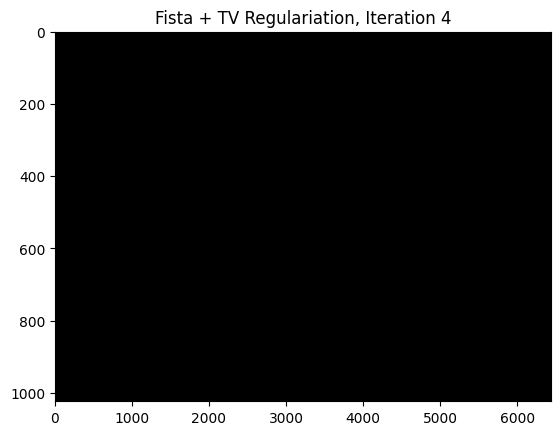

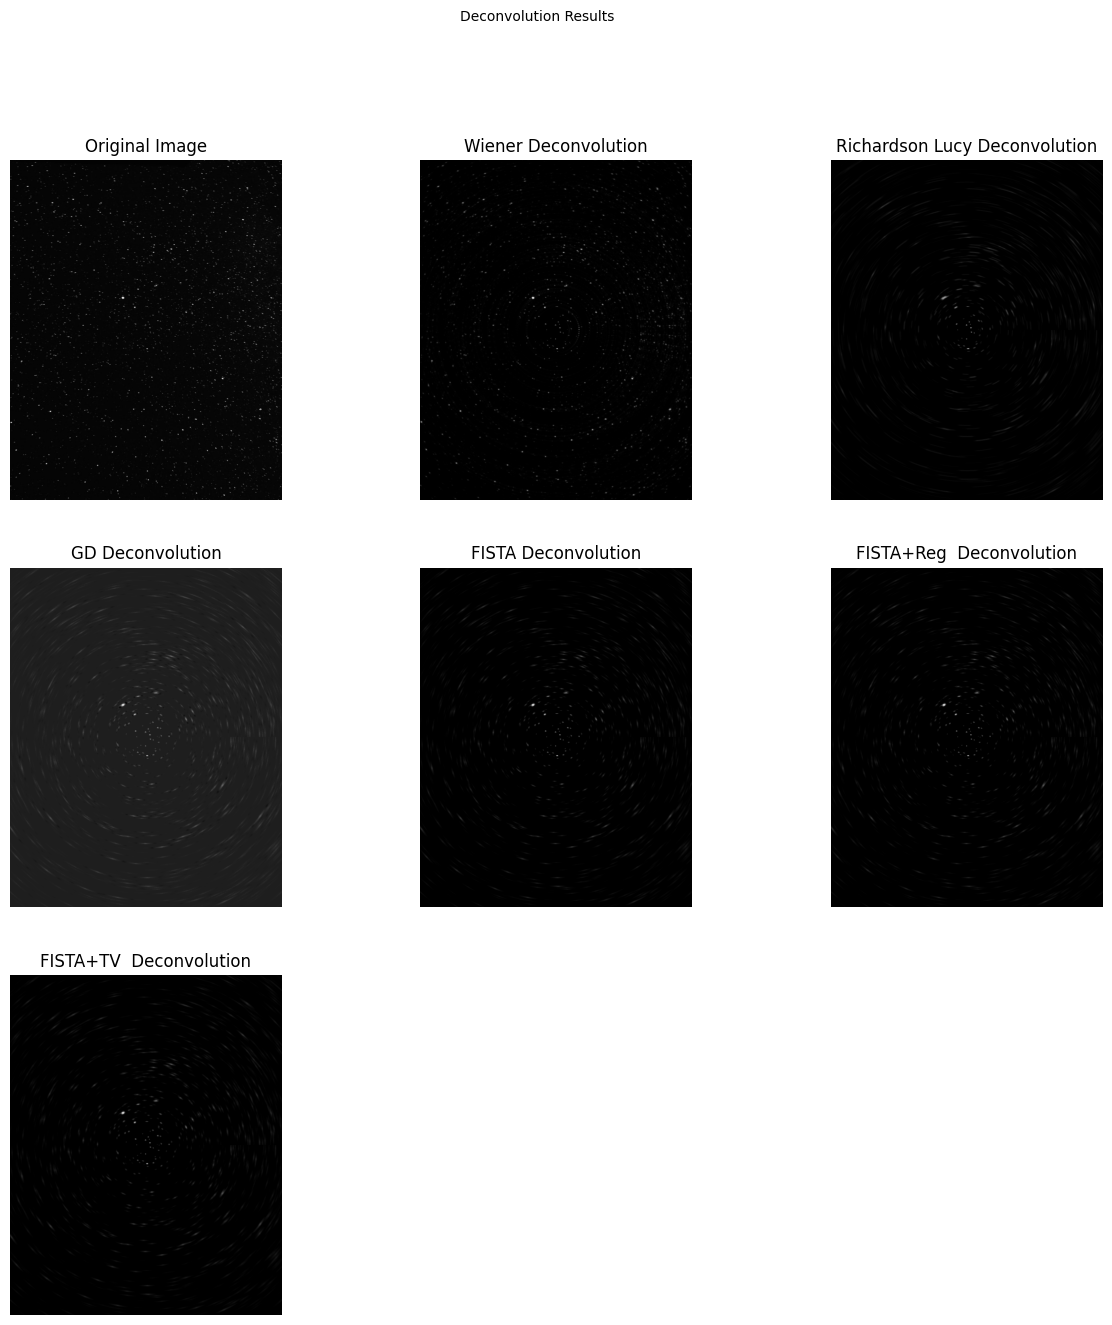

C:\Users\gsnik\AppData\Local\Temp\ipykernel_33716\2438326982.py:7: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave(os.path.join(path, key) + '.tif', val)


In [47]:
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=5)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

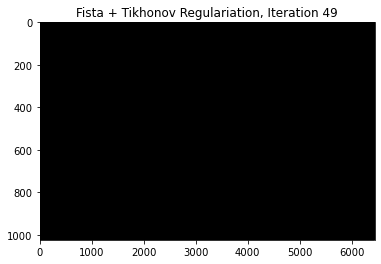

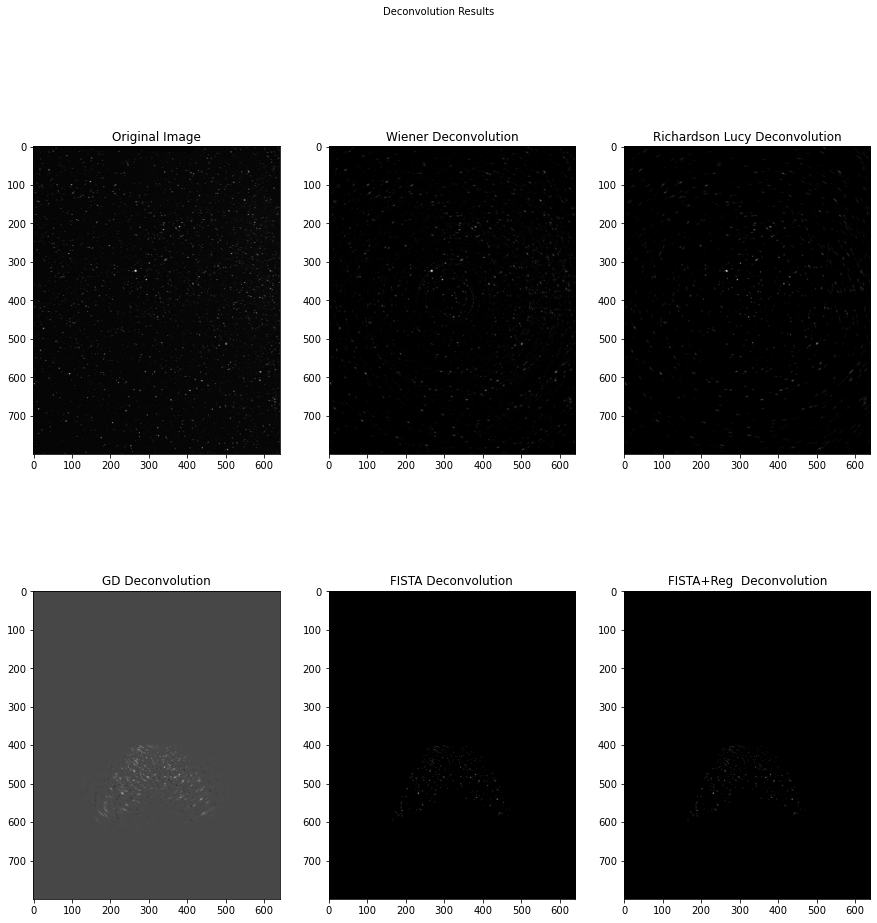

In [25]:
res_path = "results/synth_10deg/"
polar_img, psf, pad_psf, center, img = preprocessing_synthetic_images("real/stars3.jpg", th=0.2, deg=10, center=(400, 320))
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=5000)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

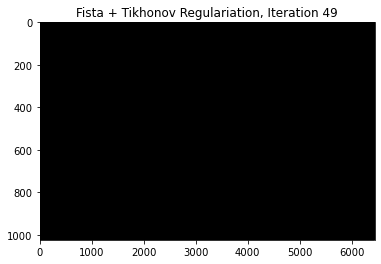

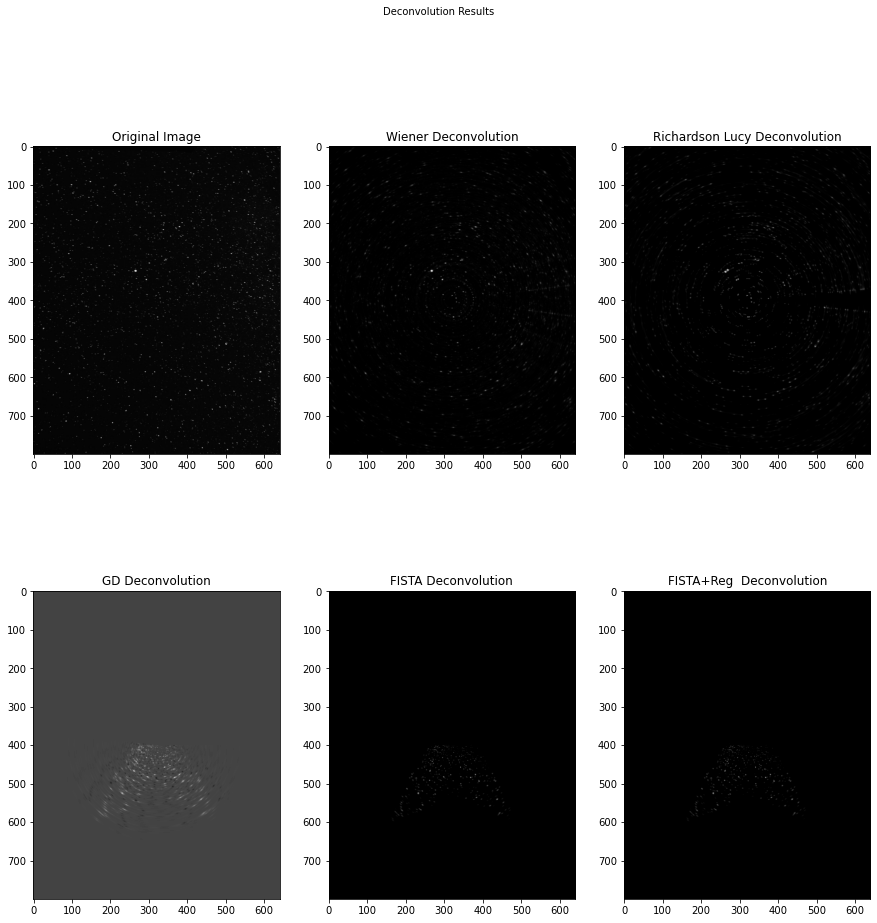

In [26]:
res_path = "results/synth_15deg/"
polar_img, psf, pad_psf, center, img = preprocessing_synthetic_images("real/stars3.jpg", th=0.2, deg=15, center=(400, 320))
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=500)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

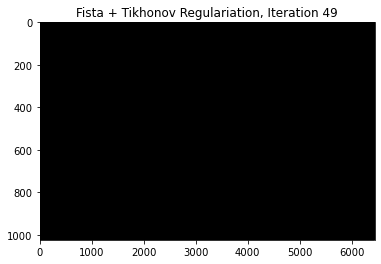

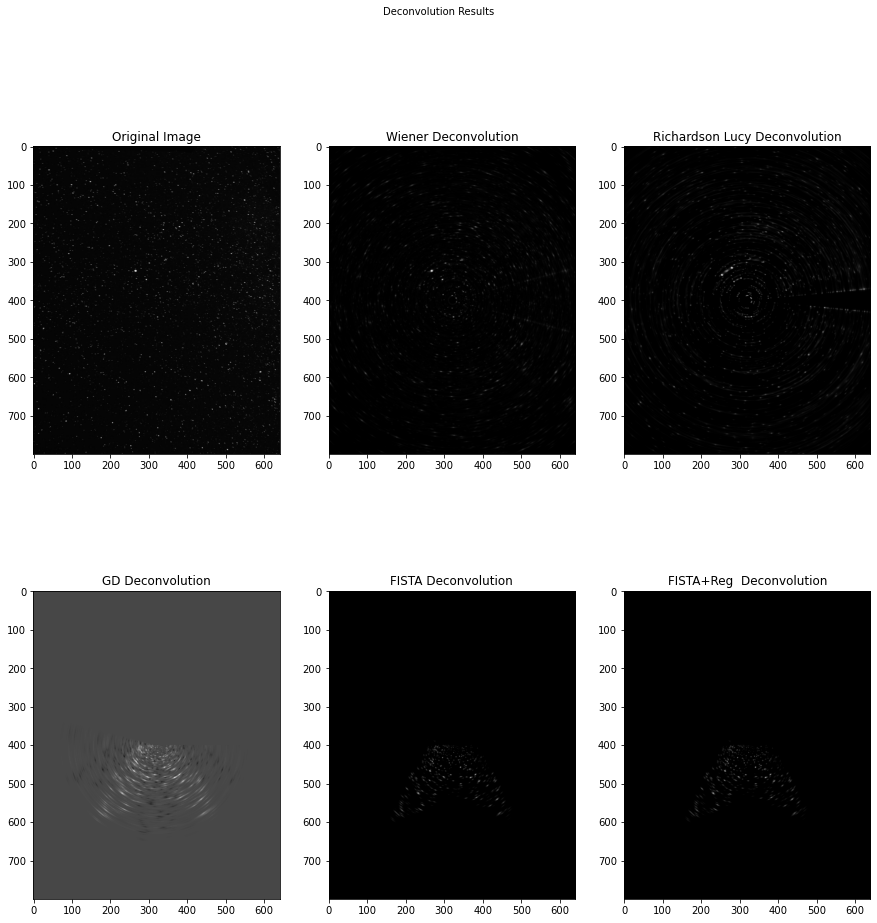

In [27]:
res_path = "results/synth_30deg/"
polar_img, psf, pad_psf, center, img = preprocessing_synthetic_images("real/stars3.jpg", th=0.2, deg=30, center=(400, 320))
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=500)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

## Real Images

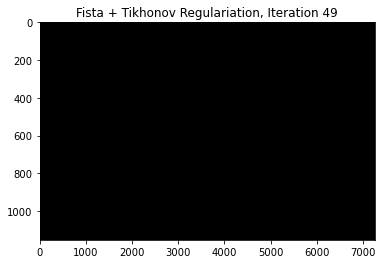

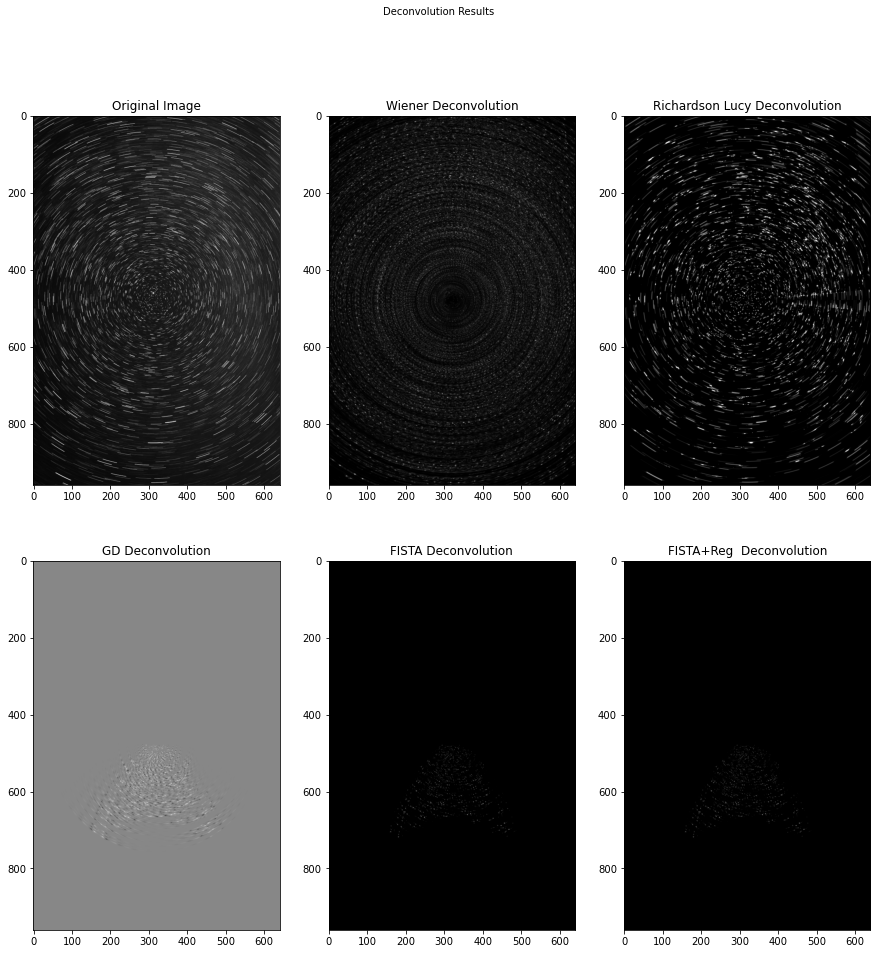

In [28]:
res_path = "results/real_30min/"
polar_img, psf, pad_psf, center, img = preprocessing_natural_image("real/star_trails_30min_small.jpg", th=0.2, center=(480, 320), time=30)
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=500)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

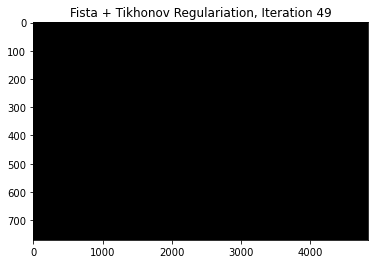

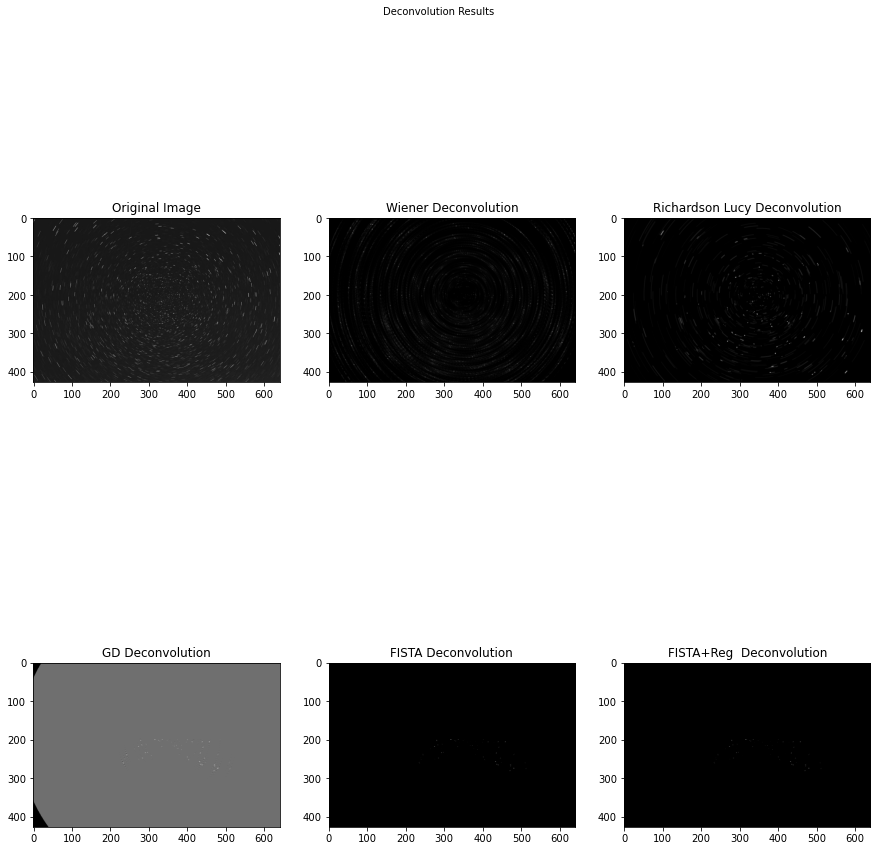

In [29]:
res_path = "results/real_10min/"
polar_img, psf, pad_psf, center, img = preprocessing_natural_image("real/star_trails_10min_small.jpg", th=0.2, center=(200, 350), time=10)
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=500)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)

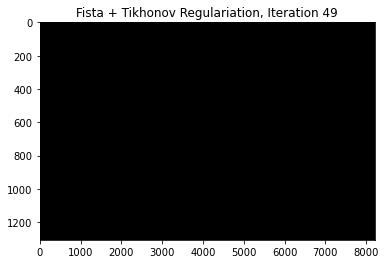

In [ ]:
res_path = "results/real_05min/"
polar_img, psf, pad_psf, center, img = preprocessing_natural_image("real/star_trails_5min_small.jpg", th=0.2, center=(450, 350), time=5)
recon_images = perform_deconvolution(polar_img, psf, pad_psf, center, img, iterations=500)
save_images(recon_images, res_path)
compute_stats(img, recon_images, res_path)